In [1]:
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Set working directory
os.chdir("..") # Go one level up
os.getcwd()

'/Users/miguelibarra/PycharmProjects/cin'

In [95]:
data_folder = os.path.abspath("/Users/miguelibarra/Documents/")
print(data_folder)

/Users/miguelibarra/Documents


In [96]:
# Read file-well info
well_file = pd.read_csv("original_well_file.csv", index_col=0, dtype={"file":str})
well_file.well.value_counts()

A375 kif2a  + dox    33
A375 + dox           30
A375 dnMCAK + dox    27
A375 kif2c - dox     27
A375 - dox           26
A375 dnMCAK - dox    26
A375 kif2c + dox     24
A375 kif2a - dox     24
Name: well, dtype: int64

In [97]:
# Read file with number of micronuclei per Snap
mn_file_counted = pd.read_table("labels/micronuclei_per_slide_image_count.tsv")
mn_file_counted

,file,cells,micronuclei
0,a375,4,0
1,1972,13,2
2,1973,9,0
3,1974,7,1
4,1975,9,2
...,...,...,...
211,2359,9,1
212,2360,15,2
213,2361,18,3
214,2362,17,2


In [98]:
# Read in cropped nuclei predictions
threshold = 0.85
mn_predict = pd.read_csv("predictions/predictions_lindsay_all.csv")
mn_predict["name"] = mn_predict["image"].apply(lambda x: "_".join([x.split(".")[0].replace("Snap-","").replace("_new",""), x.split("_")[-1].replace(".png","")]))
mn_predict["micronuclei"] = (mn_predict["prediction"] > threshold).astype(int)
mn_predict = mn_predict[["name", "micronuclei"]]

# Collapse single cell predictions into file predictions
mn_predict["file"] = mn_predict["name"].apply(lambda x: x.split("_")[0]).astype(str)

In [99]:
# Aggregate the results number of cells / number of micronuclei per file (Snap-*)
mn_file_predicted = pd.DataFrame()
mn_file_predicted["cells"] = mn_predict.groupby("file").count()["name"]
mn_file_predicted["micronuclei"] = mn_predict.groupby("file").sum()["micronuclei"]
mn_file_predicted = mn_file_predicted.reset_index()
mn_file_predicted

,file,cells,micronuclei
0,1974,9,1
1,1975,9,1
2,1976,7,1
3,1977,7,3
4,1978,8,2
...,...,...,...
201,2396,16,2
202,2398,17,4
203,2399,7,3
204,2400,6,0


In [100]:
# Merge datasets, so we can work only with files present in both predicted and counted
mn_comparable = pd.merge(mn_file_counted, mn_file_predicted, on="file", suffixes=["_counted","_predicted"])

# Add well information
mn_comparable = pd.merge(mn_comparable, well_file, on="file")

In [110]:
comparable_cells = mn_comparable.groupby("well").sum().reset_index().melt(id_vars=["well"], value_vars=["cells_predicted", 'cells_counted'], var_name="cell_prediction", value_name="cells")
comparable_micro = mn_comparable.groupby("well").sum().reset_index().melt(id_vars=["well"], value_vars=["micronuclei_predicted", 'micronuclei_counted'], var_name="micronuclei_prediction", value_name="micronuclei")

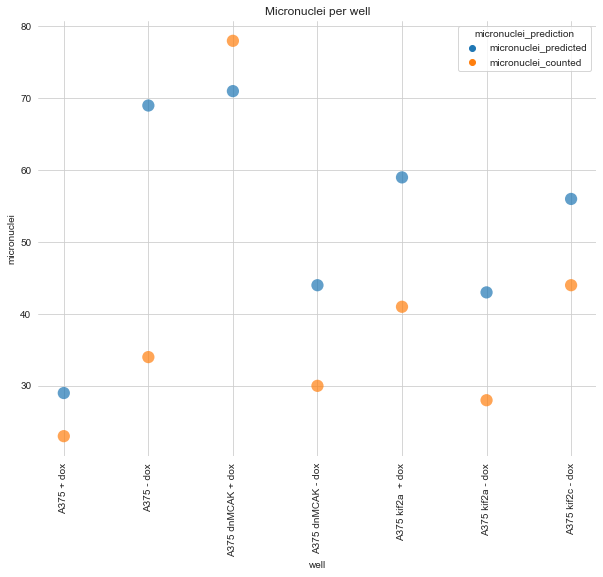

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.set_style("whitegrid")
sns.scatterplot(data=comparable_micro, x="well", y="micronuclei", hue="micronuclei_prediction", s=150, linewidth=0, alpha=0.7)
sns.despine(left=True, bottom=True)
ax.set_title("Micronuclei per well")
ax.tick_params(axis='x', labelrotation=90)

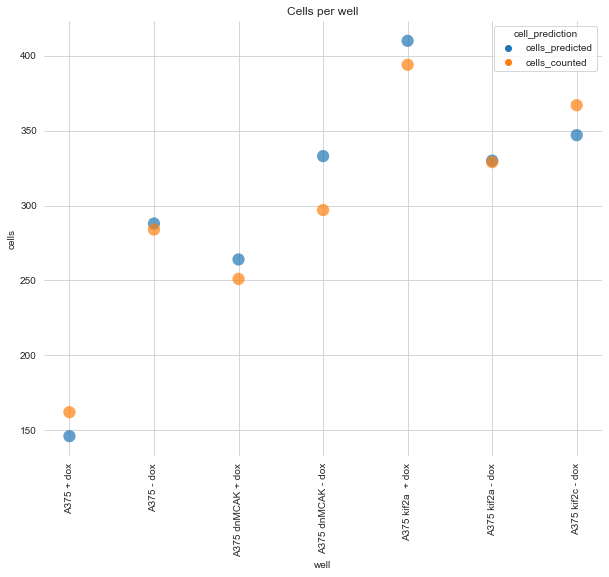

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.set_style("whitegrid")
sns.scatterplot(data=comparable_cells, x="well", y="cells", hue="cell_prediction", s=150, linewidth=0, alpha=0.7)
sns.despine(left=True, bottom=True)
ax.set_title("Cells per well")
ax.tick_params(axis='x', labelrotation=90)